# Convolutional Neural Networks

In this notebook, we will cover training a simple convolutional neural network on the MNIST dataset, visualizing tuning of model neurons, computing representational similarity analysis (RSA) for different model layers

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

## MNIST Dataset

We will use the classical MNIST dataset because it allows rapid training on CPUs.

In [2]:
# Download MNIST dataset
path = Path('./')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
     ])
trainset = datasets.MNIST(path, train=True, download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.MNIST(path, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

Shape of images from one batch :  torch.Size([16, 1, 28, 28])
Shape of labels from one batch :  torch.Size([16])


Text(0.5, 1.0, 'Label 6')

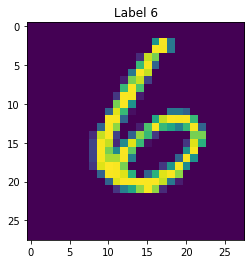

In [3]:
# Visualize an image from the dataset
for i, data in enumerate(train_loader):
    images, labels = data
    break
print('Shape of images from one batch : ', images.shape)
print('Shape of labels from one batch : ', labels.shape)

plt.imshow(images[0, 0])
plt.title('Label {}'.format(labels[0]))

## Define a convolutional neural network

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 7*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Set whether to readout activation
        self.readout = False

    def forward(self, x):
        # Max pooling over a (2, 2) window
        l1 = F.max_pool2d(F.relu(self.conv1(x)), 2)
        l2 = F.max_pool2d(F.relu(self.conv2(l1)), 2)
        l2_flat = torch.flatten(l2, start_dim=1)  # flatten tensor, while keeping batch dimension
        l3 = F.relu(self.fc1(l2_flat))
        l4 = F.relu(self.fc2(l3))
        y = self.fc3(l4)
        
        if self.readout:
            return {'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'y': y}
        else:
            return y

## Training the network

The following code trains the above network on MNIST until it reaches 95% accuracy. It should take only ~500-1000 training steps.

In [13]:
import torch.optim as optim

# Instantiate the network and print information
net = Net()
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
for i, data in enumerate(train_loader):
    image, label = data

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()    # Does the update

    # prediction
    prediction = torch.argmax(output, axis=-1)
    acc = torch.mean((label == prediction).float())

    running_loss += loss.item()
    running_acc += acc
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(
            i+1, running_loss, running_acc))
        if running_acc > 0.95:
            break
        running_loss, running_acc = 0, 0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Step 100, Loss 0.9862, Acc 0.658
Step 200, Loss 0.3212, Acc 0.908
Step 300, Loss 0.2957, Acc 0.920
Step 400, Loss 0.2359, Acc 0.939
Step 500, Loss 0.2057, Acc 0.943
Step 600, Loss 0.1827, Acc 0.952


## Compute representation similarity

We will first compute the neural responses to a batch of images

In [14]:
for i, data in enumerate(test_loader):
    images, labels = data
    break

# Readout network activity
net.readout = True
activity = net(images)

n_images = len(labels)

ind = np.argsort(labels.numpy())
labels = labels[ind]

similarity = dict()
for key, val in activity.items():
    new_val = val.detach().numpy()[ind]
    new_val = new_val.reshape(n_images, -1)
    activity[key] = new_val
    similarity[key] = np.corrcoef(new_val)

Here we plot the representational dissimilarity matrix for neural responses of different layers

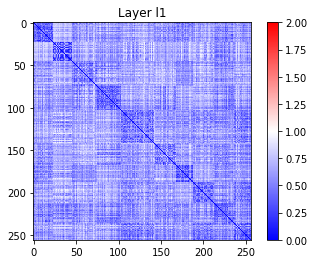

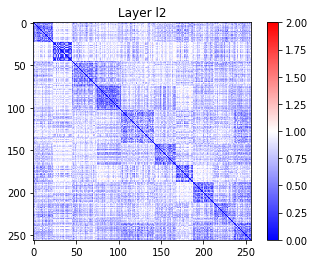

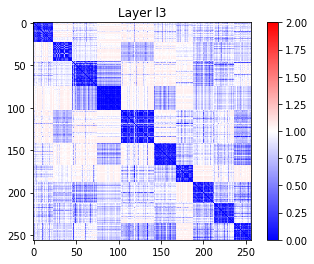

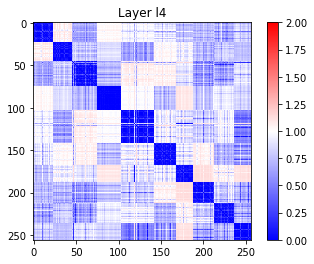

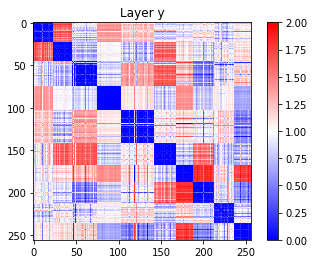

In [15]:
for layer, sim in similarity.items():
    plt.figure()
    plt.imshow(1 - sim, vmin=0, vmax=2, cmap='bwr')
    plt.colorbar()
    plt.title('Layer ' + layer)

## Search for preferred stimulus for a given neuron

We will optimize images (not weights) such as the activity of a chosen neuron is maximized

In [16]:
# Freeze for parameters in the network
for param in net.parameters():
    param.requires_grad = False
    

# Here syn_image is the variable to be optimized
# Initialized randomly for search in parallel
batch_size = 64
image_size = [batch_size] + list(images.shape[1:])
syn_image_init = np.random.rand(*image_size)
syn_image = torch.tensor(syn_image_init, requires_grad=True, dtype=torch.float32)

# Use Adam optimizer
optimizer = optim.Adam([syn_image], lr=0.01)

running_loss = 0
for i in range(1000):
    optimizer.zero_grad()   # zero the gradient buffers
    syn_image.data.clamp_(min=0.0, max=1.0)
    syn_image_transform = (syn_image - 0.1307) / 0.3081
    activity = net(syn_image_transform)
    
    # Pick a neuron, and minimize its negative activity
    neuron = activity['l4'][:, 0]
    if i == 0:
        neuron_init = neuron.detach().numpy()

    loss = -torch.mean(torch.square(neuron))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

neuron = neuron.detach().numpy()
syn_image = syn_image.detach().numpy()

Step 100, Loss -19.6849
Step 200, Loss -113.2433
Step 300, Loss -190.2116
Step 400, Loss -251.1361
Step 500, Loss -283.7224
Step 600, Loss -301.0656
Step 700, Loss -310.1727
Step 800, Loss -314.9135
Step 900, Loss -320.9894
Step 1000, Loss -324.2189


Plot the neural activity driven by a batch of images before and after the optimization process. After optimization, many images can drive the unit strongly.

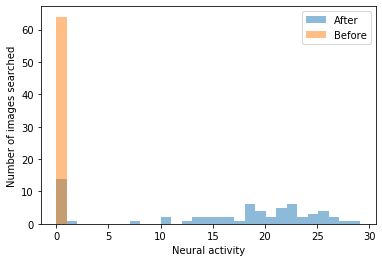

In [17]:
bins = np.linspace(0, np.max(neuron), 30)
plt.figure()
plt.hist(neuron, bins, label='After', alpha=0.5)
plt.hist(neuron_init, bins, label='Before', alpha=0.5)
plt.xlabel('Neural activity')
plt.ylabel('Number of images searched')
plt.legend()

Visualize the image that most strongly activates the chosen unit, before and after optimization.

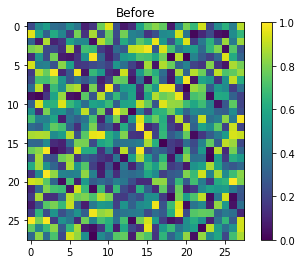

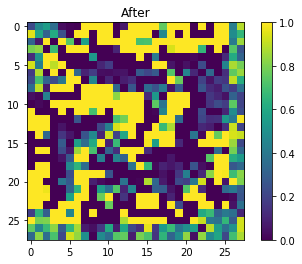

In [18]:
ind = np.argsort(neuron)
plt.figure()
plt.title('Before')
plt.imshow(syn_image_init[ind[-1], 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure()
plt.title('After')
plt.imshow(syn_image[ind[-1], 0], vmin=0, vmax=1)
plt.colorbar()